# Cognizant - Data Scientist Task - Anomaly Detection
(C) Aleksandras Urbonas, 2018

# Introduction: Anomaly Detection 

Anomaly detection is a technique used to identify unusual patterns that do not conform to expected behavior, called outliers. It has many applications in business, from intrusion detection (identifying strange patterns in network traffic that could signal a hack) to system health monitoring (spotting a malignant tumor in an MRI scan), and from fraud detection in credit card transactions to fault detection in operating environments.

This overview will cover several methods of detecting anomalies, as well as how to build a detector in Python using simple moving average (SMA) or low-pass filter. 



# What Are Anomalies?

It is important to establish some boundaries on the definition of an anomaly first. Anomalies can be broadly categorized as:
- Point anomalies: A single instance of data is anomalous, if it is too far off from the rest. Business use case: Detecting credit card fraud based on "amount spent."
- Contextual anomalies: The abnormality is context specific. This type of anomaly is common in time-series data. Business use case: Spending 100 dollars on food every day during the holiday season is normal, but may be odd otherwise.
- Collective anomalies: A set of data instances collectively helps in detecting anomalies. Business use case: Someone is trying to copy data form a remote machine to a local host unexpectedly, an anomaly that would be flagged as a potential cyber attack.

Anomaly detection is similar to — but not entirely the same as — noise removal and novelty detection:
- Novelty detection (ND) is concerned with identifying an unobserved pattern in new observations not included in training data — like a sudden interest in a new channel on YouTube during Christmas, for instance.
- Noise removal (NR) is the process of immunizing analysis from the occurrence of unwanted observations; in other words, removing noise from an otherwise meaningful signal.



# Anomaly Detection Techniques

## Simple Statistical Methods

The simplest approach to identifying irregularities in data is to flag the data points that deviate from common statistical properties of a distribution, including mean, median, mode, and quantiles. Let us say the definition of an anomalous data point is one that deviates by a certain standard deviation from the mean. Traversing mean over time-series data is not exactly trivial, as it is not static. You would need a rolling window to compute the average across the data points. Technically, this is called a rolling average or a moving average, and it is intended to smooth short-term fluctuations and highlight long-term ones. Mathematically, an n-period simple moving average can also be defined as a "low pass filter." (A Kalman filter is a more sophisticated version of this metric; you can find a very intuitive explanation of it (here:http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/).)


## Challenges

The low pass filter allows you to identify anomalies in simple use cases, but there are certain situations where this technique will not work. Here are a few:  

- The data contains noise which might be similar to abnormal behavior, because the boundary between normal and abnormal behavior is often not precise. 
- The definition of abnormal or normal may frequently change, as malicious adversaries constantly adapt themselves. Therefore, the threshold based on moving average may not always apply.
- The pattern is based on seasonality. This involves more sophisticated methods, such as decomposing the data into multiple trends in order to identify the change in seasonality.


## Machine Learning-Based Approaches

Below is a brief overview of popular machine learning-based techniques for anomaly detection. 


### Density-Based Anomaly Detection 

Density-based anomaly detection is based on the k-nearest neighbors algorithm.

Assumption: Normal data points occur around a dense neighborhood and abnormalities are far away.

The nearest set of data points are evaluated using a score, which could be Eucledian distance or a similar measure dependent on the type of the data (categorical or numerical). They could be broadly classified into two algorithms:

- K-nearest neighbor: k-NN is a simple, non-parametric lazy learning technique used to classify data based on similarities in distance metrics such as Eucledian, Manhattan, Minkowski, or Hamming distance.
- Relative density of data: This is better known as local outlier factor (LOF). This concept is based on a distance metric called reachability distance.


### Clustering-Based Anomaly Detection 

Clustering is one of the most popular concepts in the domain of unsupervised learning.

Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids.

K-means is a widely used clustering algorithm. It creates 'k' similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies.


### Support Vector Machine-Based Anomaly Detection 

A support vector machine (SVM) is another effective technique for detecting anomalies. A SVM is typically associated with supervised learning, but there are extensions (OneClassCVM, for instance) that can be used to identify anomalies as an unsupervised problems (in which training data are not labeled). The algorithm learns a soft boundary in order to cluster the normal data instances using the training set, and then, using the testing instance, it tunes itself to identify the abnormalities that fall outside the learned region.

Depending on the use case, the output of an anomaly detector could be numeric scalar values for filtering on domain-specific thresholds or textual labels (such as binary/multi labels).



# Building a Simple Detection Solution Using a Low-Pass Filter

In this section, we will focus on building a simple anomaly-detection package using moving average to identify anomalies in the sum amount of daily transactions in a sample dataset. The file has 3,143 rows, which contain information about daily transactions collected for one of customers.



### Moving Average Using Discrete Linear Convolution

_Convolution_ is a mathematical operation that is performed on two functions to produce a third function.

Mathematically, it could be described as the integral of the product of two functions, after one is reversed and shifted:

$f*g(t)$ = $\int_{-\infty}^{\infty} f(T)*g(t-T) dT$, where:

- $f(T)$ is an input function containing the quantity of interest (e.g. transactions count at time $T$)
- $g(t —T)$ is the weighting function shifted by an amount $t$.

This way as $t$ changes, different weights are assigned to the input function $f(T)$. In our case:
- $f(T)$ represents the transactions counts at time $T$,
- $g(t —T)$ is the moving average kernel.

----

# Project with Python

## Setup project

In [1]:
# Libraries
import urllib.request # download from web
from __future__ import division
from itertools import count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
#%matplotlib inline

## Define custom functions

In [2]:
# User defined functions (UDF)


def moving_average(
    data
    , window_size
):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
        data (pandas.Series): independent variable
        window_size (int): rolling window size

    Returns:
    --------
        ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(
    y
    , window_size
    , sigma=1.0
):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {
        'standard_deviation': round(std, 3)
        , 'anomalies_dict': collections.OrderedDict(
            [
                # note: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
                (
                    index
                    , y_i
                )
                for index, y_i, avg_i in zip(count(), y, avg)
                if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))
            ]
        )
       }


def explain_anomalies_rolling_std(
    y
    , window_size
    , sigma=1.0
):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    #testing_std = pd.rolling_std(residual, window_size)
    # change to: s.rolling(3).std() https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.window.Rolling.std.html
    testing_std = residual.rolling(window_size).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(
        np.nan
        , testing_std_as_df.iloc[window_size - 1]
    ).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {
        'stationary standard_deviation': round(std, 3)
        , 'anomalies_dict': collections.OrderedDict(
            [
                # looping with index: http://treyhunner.com/2016/04/how-to-loop-with-indexes-in-python/
                (index, y_i) for index, y_i, avg_i, rs_i in zip(count(), y, avg_list, rolling_std) if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))
            ]
        )
    }


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(
    x
    , y
    , window_size
    , sigma_value=1
    , title_for_plot='Plot using function `plot_results`'
    , text_xlabel="X Axis"
    , text_ylabel="Y Axis"
    , applying_rolling_std=False
):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.title(title_for_plot, fontsize=20)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(
            y
            , window_size=window_size
            , sigma=sigma_value
        )
    else:
        events = explain_anomalies(
            y
            , window_size=window_size
            , sigma=sigma_value
        )

    x_anomaly = np.fromiter(
        events['anomalies_dict'].keys()
        , dtype=int
        , count=len(events['anomalies_dict'])
    )
    y_anomaly = np.fromiter(
        events['anomalies_dict'].values()
        , dtype=float
        , count=len(events['anomalies_dict'])
    )
    plt.plot(
        x_anomaly
        , y_anomaly
        , "r*"
        , markersize=12
    )

    # add grid and lines
    plt.grid(True)
    # show the plot
    plt.show()

## Get Data

In [3]:
# Load data
data = loadtxt("../4_raw-data/transaction_amount_daily.txt", float)

## Preview Data

In [4]:
# 2. View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Day', 'Sum'])
data_as_frame.head(3)

Day   Sum
0  0.0  58.0
1  1.0  62.6
2  2.0  70.0

## Review Anomalies

In [5]:
# 4. Lets play with the functions
x = data_as_frame['Day']
Y = data_as_frame['Sum']

# collect anomalies into a dict
events = explain_anomalies(Y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

Information about the anomalies model:{'standard_deviation': 11.424, 'anomalies_dict': OrderedDict([(10, 158.6), (253, 142.5), (255, 51.0), (262, 132.2), (264, 36.0), (268, 152.7), (278, 31.1), (349, 109.3), (352, 238.9), (361, 165.7), (818, 96.2), (986, 93.4), (1055, 206.3), (1069, 84.8), (1172, 107.1), (1182, 52.2), (1185, 180.4), (1464, 88.3), (1735, 129.2), (1882, 107.2), (1890, 103.6), (1897, 108.2), (2023, 154.5), (2025, 72.2), (2027, 129.3), (2171, 108.0), (2274, 165.3), (2380, 201.3), (2390, 94.8), (2391, 189.7), (2503, 158.0), (2518, 152.3), (2520, 217.4), (2521, 143.1), (2527, 199.6), (2755, 58.1), (2756, 138.2), (2789, 90.9), (2807, 127.0), (2885, 196.2), (2886, 126.9), (2897, 105.4), (2899, 200.3), (3005, 137.7), (3018, 170.1), (3032, 150.7)])}


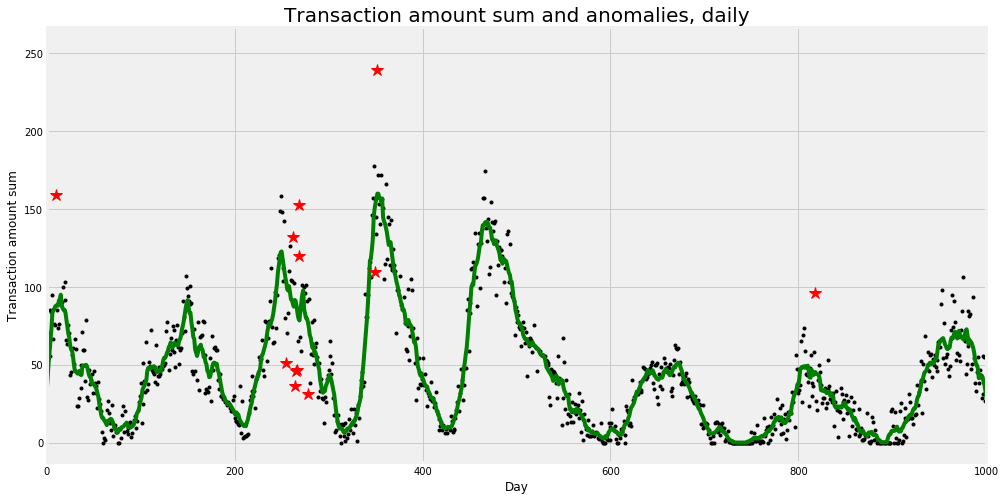

In [6]:
plot_results(
    x
    , y=Y
    , window_size=10
    , sigma_value=3
    , title_for_plot="Transaction amount sum and anomalies, daily"
    , text_xlabel="Day"
    , text_ylabel="Transaction amount sum"
)

## Compare with random data

Let's see if the above anomaly detection function could be used for another use case. Let's assume that we generate a random dataset that hypothetically relates to Company A's stock value over a period of time. The x axis represents time in days (since 2013) and the y axis represents the value of the stock in dollars.

In [7]:
# Convenience function to add noise
def noise(yval):
    """ Helper function to generate random points """
    np.random.seed(0)
    return 0.2 * np.asarray(yval) * np.random.normal(size=len(yval))


# Generate a random dataset
def generate_random_dataset(size_of_array=1000, random_state=1235):
    """ Helps in generating a random dataset which has a normal distribution
    Args:
    -----
        size_of_array (int): number of data points
        random_state (int): to initialize a random state

    Returns:
    --------
        a list of data points for dependent variable, pandas.Series of independent variable
    """
    # generate X: start with all 0
    x = range(0, size_of_array)
    # generate Y
    np.random.seed(random_state)
    # fill will random values (mean=0, sd=0.5)
    y = np.random.normal(0, 0.5, size_of_array)
    y_new = [
        y_i + index**((size_of_array - index)/size_of_array) for index, y_i in zip(count(), y)
    ]
    y_new += noise(y)
    return x, pd.Series(y_new)

Let us play!

In [8]:
x1, y1 = generate_random_dataset()

In [9]:
y1 += y1 + noise(y1)

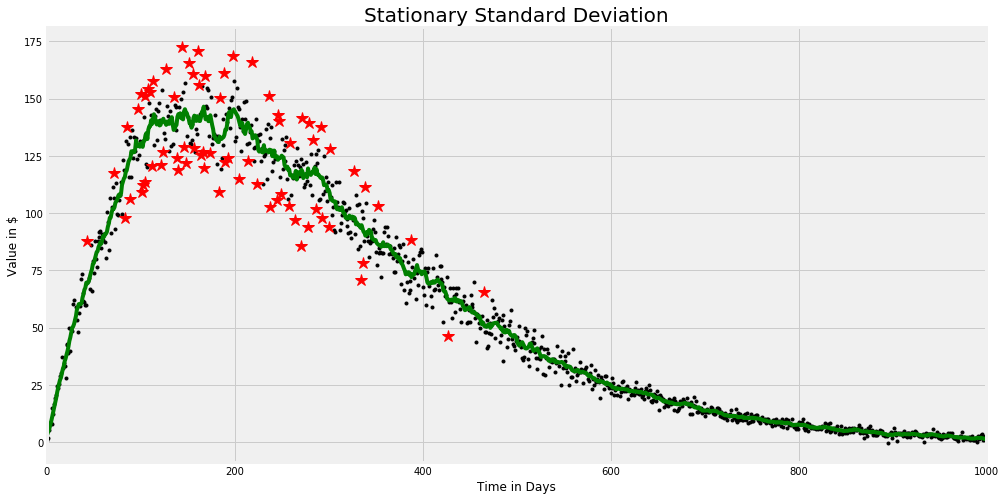

In [10]:
# Using stationary standard deviation over a continuous sample replicating
plot_results(
    x1
    , y1
    , window_size=12
    , sigma_value=2
    , title_for_plot="Stationary Standard Deviation"
    , text_xlabel="Time in Days"
    , text_ylabel="Value in $"
)

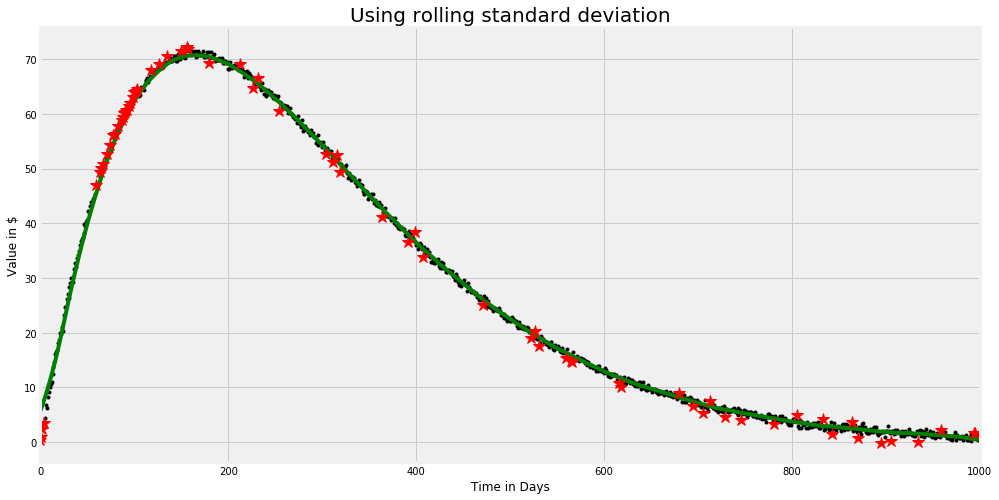

In [11]:
# using rolling standard deviation for
x1, y1 = generate_random_dataset()

plot_results(
    x1
    , y1
    , window_size=50
    , sigma_value=2
    , title_for_plot="Using rolling standard deviation"
    , text_xlabel="Time in Days"
    , text_ylabel="Value in $"
    , applying_rolling_std=True
)

## Conclusion

Looks like our anomaly detector is doing a decent job. It is able to detect data points that are 2 sigma away from the fitted curve. Depending on the distribution of a use case in a time-series setting, and the dynamicity of the environment, you may need to use stationary (global) or non-stationary (local) standard deviation to stabilize a model. The mathematical function around the standard deviation could be modified very easily to use a customized formulation.

**Note**: The analyses above are intended is to highlight how you can quickly build a simple anomaly detector. They are not necessarily the most efficient solution.